In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def display_image(title, image, cmap='gray'):
    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

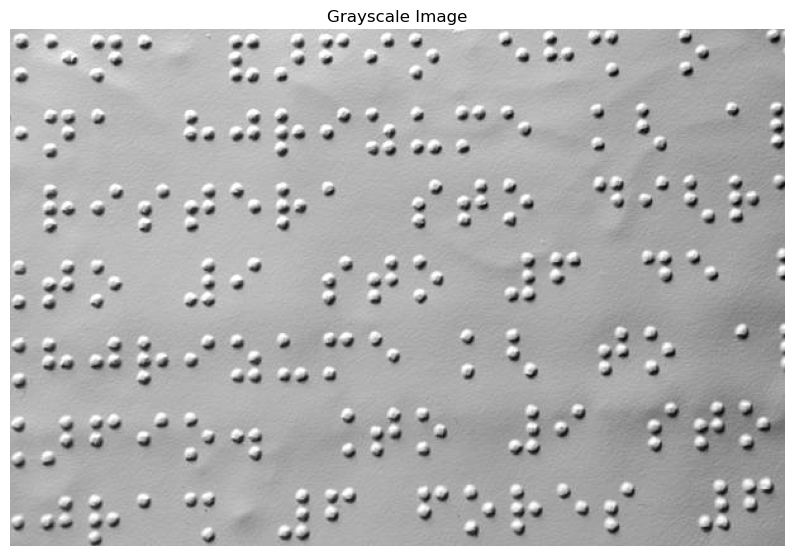

In [16]:
# Step 1: Import and Preprocess the Image
img = cv2.imread('./raw_dataset/img9.jpg')
if img is None:
    raise FileNotFoundError(f"Image not found at {'./raw_dataset/img4.jpg'}")
image = img.copy()

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

display_image("Grayscale Image", gray)

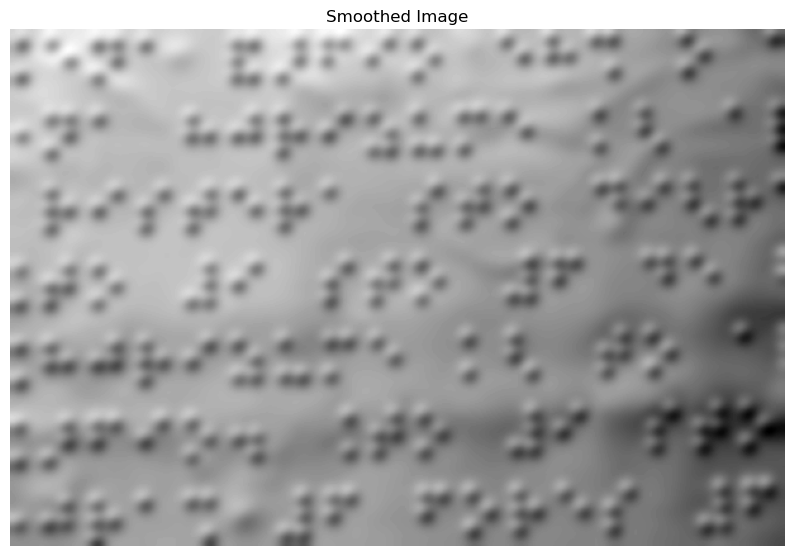

In [17]:
# Noise Reduction
smoothed = cv2.GaussianBlur(gray, (29, 29), 0)
display_image("Smoothed Image", smoothed)

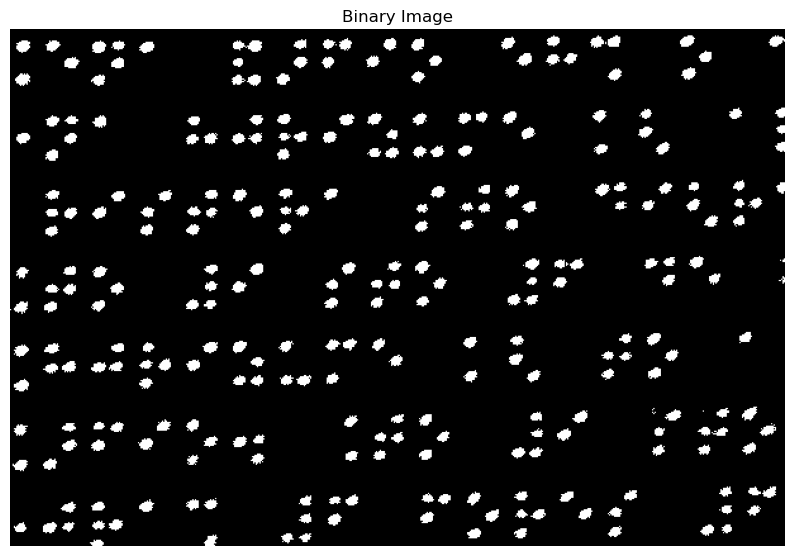

In [18]:
# Step 3: Segment the Braille Characters
binary = cv2.adaptiveThreshold(smoothed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
display_image("Binary Image", binary)

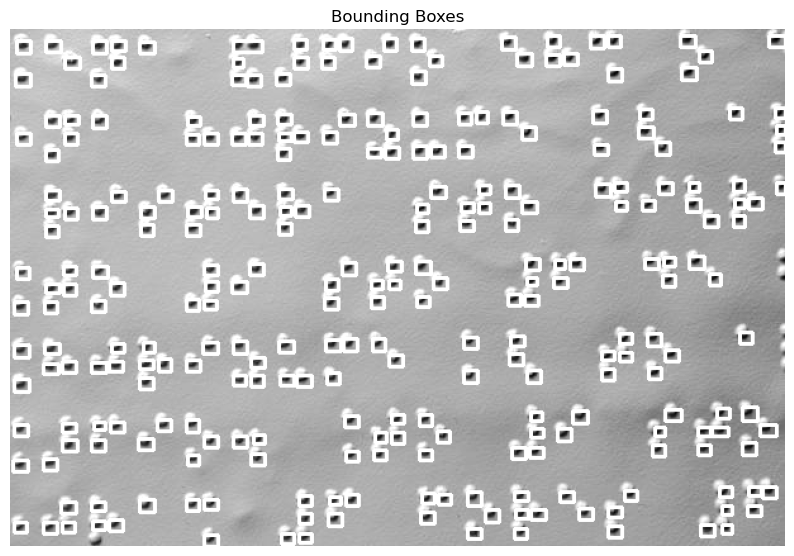

In [19]:
dot_contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter and Display Contours
output = gray.copy()
min_width, min_height = 5, 5  # Adjust based on Braille dot size
cropped_images = []

for contour in dot_contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > min_width and h > min_height:
        cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cropped = gray[y:y + h, x:x + w]
        cropped_images.append(cropped)

# Display the image with bounding boxes
display_image("Bounding Boxes", output)

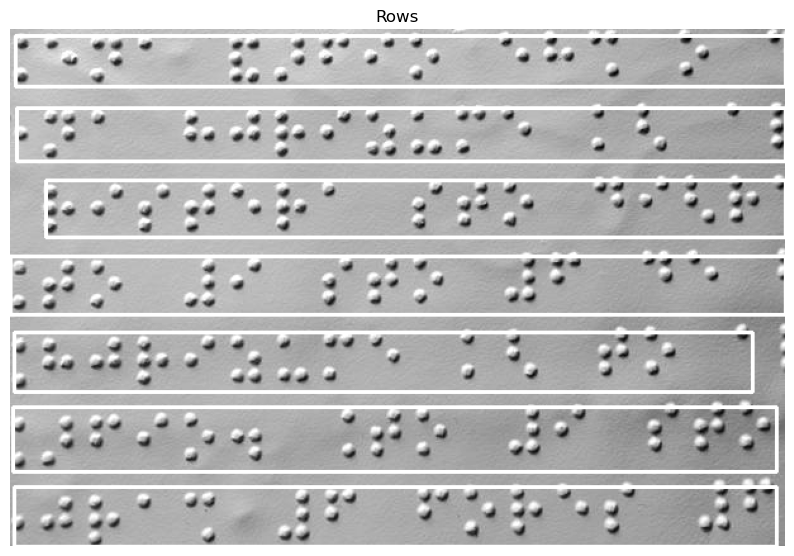

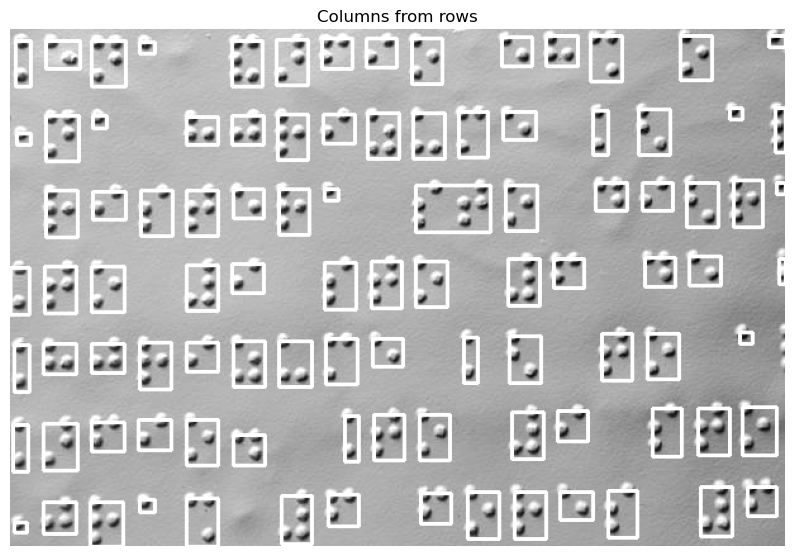

In [20]:
import numpy as np

# Parameters (adjust based on Braille dot size and spacing)
# We will start with 20*20 but we will make it dynamic later
dot_spacing_threshold = 20  # Distance threshold to group dots into a row
letter_spacing_threshold = 20  # Distance threshold to group rows into letters

# Sort contours by y, then x
dot_contours = sorted(dot_contours, key=lambda cnt: (cv2.boundingRect(cnt)[1], cv2.boundingRect(cnt)[0]))

# Group dots into rows
rows = []
current_row = []
previous_y = None

for contour in dot_contours:
    x, y, w, h = cv2.boundingRect(contour)
    center_y = y + h // 2

    if previous_y is None or abs(center_y - previous_y) < dot_spacing_threshold:
        current_row.append((x, y, w, h))
    else:
        rows.append(current_row)
        current_row = [(x, y, w, h)]
    previous_y = center_y

if current_row:
    rows.append(current_row)
    
# Display the extracted letters
output2 = gray.copy()
for row in rows:
    min_x = min([x for x, y, w, h in row])
    min_y = min([y for x, y, w, h in row])
    max_x = max([x + w for x, y, w, h in row])
    max_y = max([y + h for x, y, w, h in row])
    cv2.rectangle(output2, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
display_image("Rows", output2)

# Group rows into letters
letters = []
for row in rows:
    row = sorted(row, key=lambda b: b[0])  # Sort by x-coordinate
    current_letter = []
    previous_x = None

    for bbox in row:
        x, y, w, h = bbox
        center_x = x + w // 2

        if previous_x is None or abs(center_x - previous_x) < letter_spacing_threshold:
            current_letter.append(bbox)
        else:
            letters.append(current_letter)
            current_letter = [bbox]
        previous_x = center_x

    if current_letter:
        letters.append(current_letter)
        
        
output3 = gray.copy()
for letter in letters:
    min_x = min([x for x, y, w, h in letter])
    min_y = min([y for x, y, w, h in letter])
    max_x = max([x + w for x, y, w, h in letter])
    max_y = max([y + h for x, y, w, h in letter])
    cv2.rectangle(output3, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
display_image("Columns from rows", output3)

# Extract and save each letter
letter_images = []
for letter in letters:
    # Find the bounding box for the entire letter
    min_x = min([x for x, y, w, h in letter])
    min_y = min([y for x, y, w, h in letter])
    max_x = max([x + w for x, y, w, h in letter])
    max_y = max([y + h for x, y, w, h in letter])

    # Crop the letter region
    letter_image = gray[min_y:max_y, min_x:max_x]
    letter_images.append(letter_image)

# Display the extracted letters
# for i, letter_image in enumerate(letter_images):
#     display_image(f"Letter {i+1}", letter_image)


In [22]:
def normalize_to_grid(letter_bboxes, grid_size=(3, 2)):
    min_x = min(bbox[0] for bbox in letter_bboxes)
    min_y = min(bbox[1] for bbox in letter_bboxes)
    max_x = max(bbox[0] + bbox[2] for bbox in letter_bboxes)
    max_y = max(bbox[1] + bbox[3] for bbox in letter_bboxes)
    
    width = max_x - min_x
    height = max_y - min_y
    
    grid = np.zeros(grid_size, dtype=int)
    
    for x, y, w, h in letter_bboxes:
        col = int(grid_size[1] * (x - min_x) / width)
        row = int(grid_size[0] * (y - min_y) / height)
        grid[row, col] = 1
    
    return grid


for letter in letters:
    normalized = normalize_to_grid(letter)
    print("Letter -> ",letter)
    print("Normalized grid -> \n", normalized)

Letter ->  [(4, 35, 12, 10), (5, 9, 11, 10)]
Normalized grid -> 
 [[1 0]
 [0 0]
 [1 0]]
Letter ->  [(28, 9, 12, 9), (43, 22, 12, 9)]
Normalized grid -> 
 [[1 0]
 [0 1]
 [0 0]]
Letter ->  [(64, 36, 11, 9), (65, 9, 11, 10), (80, 9, 11, 8), (80, 22, 10, 9)]
Normalized grid -> 
 [[1 1]
 [0 1]
 [1 0]]
Letter ->  [(102, 10, 12, 9)]
Normalized grid -> 
 [[1 0]
 [0 0]
 [0 0]]
Letter ->  [(175, 36, 11, 8), (176, 9, 23, 9), (176, 23, 8, 7), (187, 36, 11, 9)]
Normalized grid -> 
 [[1 0]
 [1 0]
 [1 1]]
Letter ->  [(210, 35, 11, 9), (224, 8, 10, 8), (224, 22, 11, 9)]
Normalized grid -> 
 [[0 1]
 [0 1]
 [1 0]]
Letter ->  [(246, 22, 10, 9), (247, 8, 10, 8), (257, 12, 1, 1), (260, 7, 10, 10)]
Normalized grid -> 
 [[1 1]
 [1 0]
 [0 0]]
Letter ->  [(281, 21, 11, 9), (295, 7, 10, 10)]
Normalized grid -> 
 [[0 1]
 [1 0]
 [0 0]]
Letter ->  [(317, 7, 10, 10), (317, 33, 11, 10), (331, 21, 10, 8)]
Normalized grid -> 
 [[1 0]
 [0 1]
 [1 0]]
Letter ->  [(388, 6, 11, 10), (400, 19, 12, 10)]
Normalized grid -> 
 